In [41]:
# Relevant imports
import torch
import sys
import matplotlib.pyplot as plt
import numpy as np
from kan import KAN

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from upinn import UPINN
from architectures import FNN
from utils import RAD_sampler, sample_collocation_points
from NavierStokesData import NavierStokesData

In [42]:
# Data points
data = NavierStokesData(samplesize=2000)
Zd = data.Zd
Ud = data.Ud

# # Get index of datapoints on the boundary
# idx = (data.Zd_full[:, 0] == 1)
# Zd = data.Zd_full[idx]
# Ud = data.Ud_full[idx]

# # # Get index of initial datapoints
# # idx = (data.Zd_full[:, 2] == 0)
# # Zd = data.Zd_full[idx]
# # Ud = data.Ud_full[idx]

In [43]:
# Collocation points
N_coll = 10000
Xc = sample_collocation_points(N_coll, 3, [1, -2, 0], [8, 2, 20], method='sobol')

In [44]:
def compute_grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True, retain_graph=True)[0]

class NavierStokes(torch.nn.Module):
    def __init__(self, lambda1, lambda2):
        super(NavierStokes, self).__init__()
        self.lambda1 = lambda1
        self.lambda2 = lambda2


    def forward(self, Z, U):

        psi = U[:, 0:1]
        p = U[:, 1:2]

        U_z = compute_grad(psi, Z)

        psi_x = U_z[:, 0:1]
        psi_y = U_z[:, 1:2]

        u = psi_y
        v = -psi_x

        u_z = compute_grad(u, Z)
        u_x = u_z[:, 0:1]
        u_y = u_z[:, 1:2]
        u_t = u_z[:, 2:3]

        v_z = compute_grad(v, Z)
        v_x = v_z[:, 0:1]
        v_y = v_z[:, 1:2]
        v_t = v_z[:, 2:3]

        p_z = compute_grad(p, Z)
        p_x = p_z[:, 0:1]
        p_y = p_z[:, 1:2]

        u_xx = compute_grad(u_x, Z)[:, 0:1]
        u_yy = compute_grad(u_y, Z)[:, 1:2]

        v_xx = compute_grad(v_x, Z)[:, 0:1]
        v_yy = compute_grad(v_y, Z)[:, 1:2]

        f = u_t + self.lambda1 * (u * u_x + v * u_y) + p_x # - self.lambda2 * (u_xx + u_yy)
        g = v_t + self.lambda1 * (u * v_x + v * v_y) + p_y # - self.lambda2 * (v_xx + v_yy)

        return torch.cat([f, g], dim=1)

lambda1 = 1.0
lambda2 = 0.01

N = NavierStokes(lambda1, lambda2)

In [45]:
class NavierStokesUPINN(UPINN):
    
    def score(self):

        Xtest = data.Zd_full.requires_grad_(True)

        U_pred = self.u(Xtest)
        psi_z = compute_grad(U_pred[:, 0], Xtest)
        psi_y = psi_z[:, 1:2]
        psi_x = psi_z[:, 0:1]

        data_pred = torch.cat([psi_y, -psi_x], dim=1)
        data_true = torch.mean((data_pred - data.Ud_full[:, 0:2])**2)

        return torch.nn.MSELoss()(data_pred, data_true)
    

    def score_residual(self):
        
        x_true = np.linspace(1, 8, 100)
        y_true = np.linspace(-2, 2, 50)
        u_true = data.Ud_full[:, 0].reshape(50,100)
        v_true = data.Ud_full[:, 1].reshape(50,100)

        # True residual
        u_x = np.gradient(u_true, x_true, axis=1)
        u_y = np.gradient(u_true, y_true, axis=0)

        v_x = np.gradient(v_true, x_true, axis=1)
        v_y = np.gradient(v_true, y_true, axis=0)

        u_xx = np.gradient(u_x, x_true, axis=1)
        u_yy = np.gradient(u_y, y_true, axis=0)

        v_xx = np.gradient(v_x, x_true, axis=1)
        v_yy = np.gradient(v_y, y_true, axis=0)

        res_true_f = - lambda2 * (u_xx + u_yy)
        res_true_g = - lambda2 * (v_xx + v_yy)

        res_true = np.concatenate([res_true_f.reshape(-1,1), res_true_g.reshape(-1,1)], axis=1)

        z_test = torch.tensor(np.array(np.meshgrid(x_true, y_true)).T.reshape(-1,2)).float()
        u_test = self.u(z_test)
        res_pred = self.N(z_test, u_test).detach().numpy()
        res_pred = res_pred.reshape(50,100,2)

        residual_loss = np.mean((res_true - res_pred)**2)

        return residual_loss
        


    def data_loss(self):

        if self.data_points is not None:
            
            self.data_points[0].requires_grad_(True)

            Ud = self.u(self.data_points[0])

            psi_z = compute_grad(Ud[:, 0], self.data_points[0])
            psi_y = psi_z[:, 1:2]
            psi_x = psi_z[:, 0:1]

            # data_pred = torch.cat([psi_y, -psi_x], dim=1)
            # data_loss = torch.mean((data_pred - self.data_points[1][:, 0:2])**2)

            data_pred = torch.cat([psi_y, -psi_x, Ud[:, 1:2]], dim=1)
            data_loss = torch.mean((data_pred - self.data_points[1][:, 0:3])**2)

            # self.log.setdefault("lambda1", []).append(lambda1.item())
            # self.log.setdefault("lambda2", []).append(lambda2.item())

        else: data_loss = torch.tensor(0.0)

        return data_loss
    
    def F_input(self, Z, U):
        
        psi = U[:, 0:1]
        
        U_z = compute_grad(psi, Z)

        psi_x = U_z[:, 0:1]
        psi_y = U_z[:, 1:2]

        u = psi_y
        v = -psi_x

        return torch.cat([Z, u, v], dim=1)


    def refine_collocation_points(self):
        N = 50*N_coll
        D = N_coll
        k = 0.5
        c = 0.1

        Xc = sample_collocation_points(N, 3, lb=[1, -2, 0], ub=[8, 2, 20], method='sobol').requires_grad_(True)

        # Compute the residual
        U = self.u(Xc)
        residual = torch.sum(torch.abs(self.F(self.F_input(Xc, U)) + self.N(Xc, U)), dim=1)

        self.collocation_points = RAD_sampler(Xc, residual, D, k, c) # RAD
    


In [46]:
hidden = [20] * 8

u = FNN(
    dims=[3, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

F = FNN(
    dims=[5, *hidden, 2],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

In [47]:
model = NavierStokesUPINN(u, N, F, data_points=(Zd, Ud), collocation_points=Xc)

[Info]: Initializing UPINN model


In [48]:
adam = torch.optim.Adam(model.parameters(), lr=1e-3)
lbfgs = torch.optim.LBFGS(model.parameters(), lr=1)

In [ ]:
model.optimizer = adam
for i in range(10):
    model.train_loop(1000)
    model.save('ns-upinn-with_pressure', 'models', overwrite=True)
    model.refine_collocation_points()

[Info]: Training 5000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 5000/5000 [05:13<00:00, 15.93 epoch/s, bc_loss=0.00e+00, data_loss=1.57e-03, pde_loss=6.87e-04, loss=2.26e-03]


[Info]: Successfully saved total model with name ns-upinn-half at models
[Info]: Training 5000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 5000/5000 [05:30<00:00, 15.14 epoch/s, bc_loss=0.00e+00, data_loss=1.04e-03, pde_loss=4.63e-04, loss=1.51e-03]


[Info]: Successfully saved total model with name ns-upinn-half at models
[Info]: Training 5000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 5000/5000 [05:36<00:00, 14.85 epoch/s, bc_loss=0.00e+00, data_loss=8.91e-04, pde_loss=3.89e-04, loss=1.28e-03]


[Info]: Successfully saved total model with name ns-upinn-half at models
[Info]: Training 5000 epoch(s) on cuda using Adam optimizer.


[CUDA]:  82%|████████▏ | 4105/5000 [04:29<00:58, 15.22 epoch/s, bc_loss=0.00e+00, data_loss=6.27e-04, pde_loss=3.11e-04, loss=9.38e-04]


KeyboardInterrupt: 

In [32]:
model.optimizer = lbfgs
model.train_loop(100)

[Info]: Training 100 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 100/100 [02:46<00:00,  1.66s/ epoch, bc_loss=0.00e+00, data_loss=3.09e-05, pde_loss=3.34e-05, loss=6.43e-05]


In [28]:
model.save('ns-upinn-half', 'models', overwrite=True)

[Info]: Successfully saved total model with name ns-upinn-half at models


In [27]:
np.save('loss/ns-upinn-half.npy', np.array(model.log['loss']))

In [11]:
# model.save('nv-upinn-10000-collocation-5000-data', 'models')

In [13]:
# plt.figure(figsize=(8, 3))
# plt.plot(model.log['loss'], 'b', label='Loss')
# plt.plot(model.log['data_loss'], 'r', label='Data loss')
# plt.plot(model.log['pde_loss'], 'g', label='PDE loss')
# plt.legend()
# plt.xlim(0, 30000)
# plt.yscale('log')
# plt.xlabel('Epochs')
# plt.tight_layout()
# plt.savefig('gfx/nv-upinn-10000-collocation-5000-loss.pdf', format='pdf', bbox_inches='tight')
# plt.show()

In [17]:
plot_data = data.get_quantities(model, t=10)

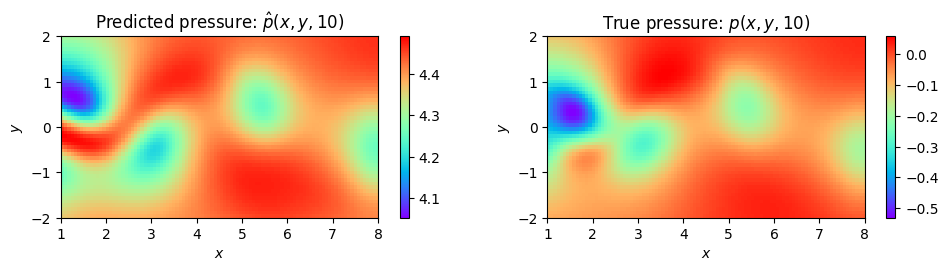

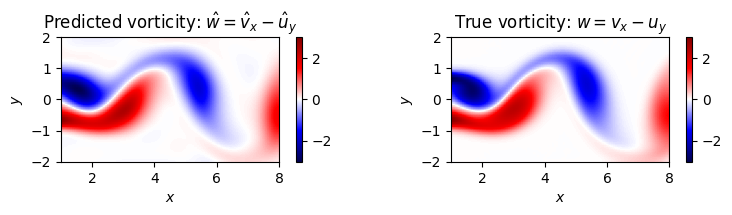

In [ ]:
plt.subplots(1, 2, figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.imshow(plot_data['p_pred'], extent=(1, 8, -2, 2), cmap='rainbow', origin='lower')
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Predicted pressure: $\hat{p}(x, y, 10)$')

plt.subplot(1, 2, 2)
plt.imshow(plot_data['p_true'], extent=(1, 8, -2, 2), cmap='rainbow', origin='lower')
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'True pressure: $p(x, y, 10)$')

plt.tight_layout()
plt.savefig('gfx/ns-upinn-half-pressure.pdf', format='pdf', bbox_inches='tight')
plt.show()



plt.subplots(1, 2, figsize=(12, 3))

v = max(np.max(abs(plot_data['omega_pred'])), np.max(abs(plot_data['omega_true'])))

plt.subplot(1, 2, 1)
plt.imshow(plot_data['omega_pred'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Predicted vorticity: $\hat{w} = \hat{v}_x - \hat{u}_y$')

plt.subplot(1, 2, 2)
plt.imshow(plot_data['omega_true'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'True vorticity: $w = v_x - u_y$')

plt.tight_layout()
# plt.savefig('gfx/ns-upinn-inverse-vorticity.pdf', format='pdf', bbox_inches='tight')
plt.show()


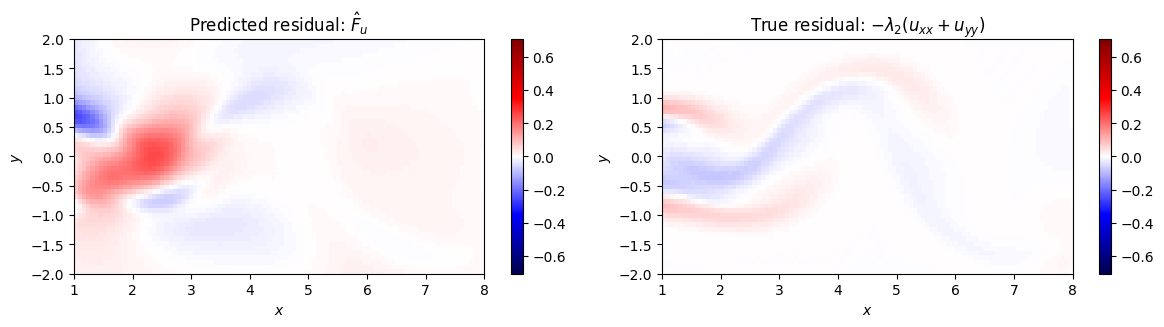

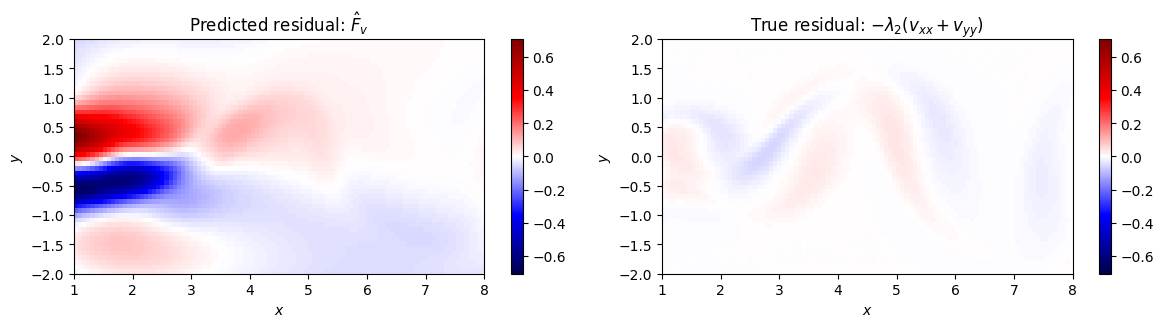

In [40]:
plt.subplots(1, 2, figsize=(12, 3))

v = max(np.max(abs(plot_data['f_res_pred'])), np.max(abs(plot_data['g_res_pred'])), np.max(abs(plot_data['f_res_true'])), np.max(abs(plot_data['g_res_true'])))

plt.subplot(1, 2, 1)
plt.imshow(plot_data['f_res_pred'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Predicted residual: $\hat{F}_u$')

plt.subplot(1, 2, 2)
plt.imshow(plot_data['f_res_true'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'True residual: $-\lambda_2 (u_{xx} + u_{yy})$')

plt.tight_layout()
# plt.savefig('gfx/ns-pinn-inverse-pressure.pdf', format='pdf', bbox_inches='tight')
plt.show()


plt.subplots(1, 2, figsize=(12, 3))

plt.subplot(1, 2, 1)

plt.imshow(plot_data['g_res_pred'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Predicted residual: $\hat{F}_v$')

plt.subplot(1, 2, 2)
plt.imshow(plot_data['g_res_true'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'True residual: $-\lambda_2 (v_{xx} + v_{yy})$')

plt.tight_layout()
# plt.savefig('gfx/ns-pinn-inverse-pressure.pdf', format='pdf', bbox_inches='tight')
plt.show()


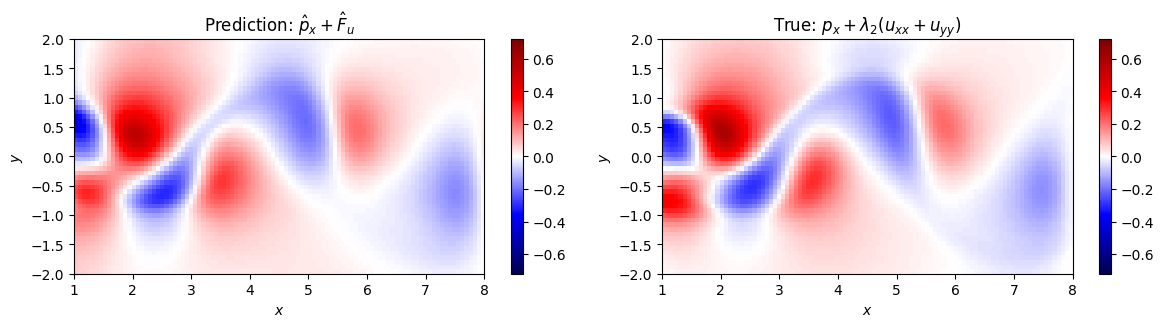

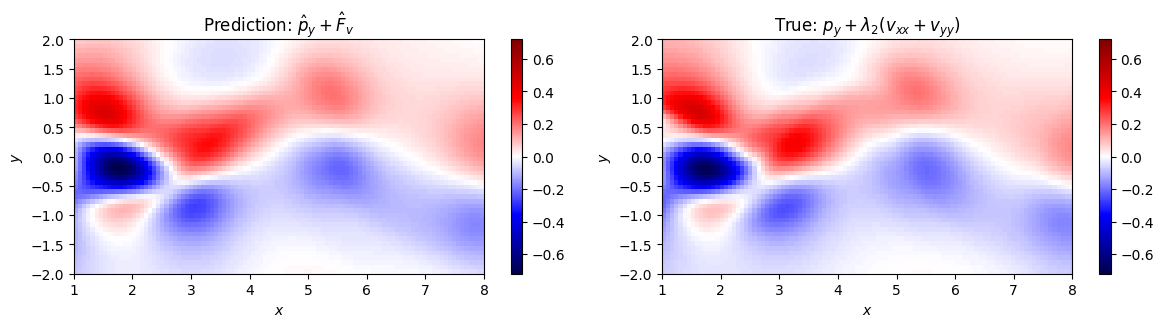

In [39]:
v = max(np.max(abs(plot_data['px_pred']+plot_data['f_res_pred'])), np.max(abs(plot_data['py_pred']+plot_data['g_res_pred'])), np.max(abs(plot_data['px_true']+plot_data['f_res_true'])), np.max(abs(plot_data['py_true']+plot_data['g_res_true'])))

plt.subplots(1, 2, figsize=(12, 3))

plt.subplot(1, 2, 1)

plt.imshow(plot_data['px_pred'] + plot_data['f_res_pred'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Prediction: $\hat{p}_x + \hat{F}_u$')

plt.subplot(1, 2, 2)
plt.imshow(plot_data['px_true'] + plot_data['f_res_true'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'True: $p_x + \lambda_2 (u_{xx} + u_{yy})$')

plt.tight_layout()
plt.savefig('gfx/ns-upinn-half-respred.pdf', format='pdf', bbox_inches='tight')
plt.show()


plt.subplots(1, 2, figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.imshow(plot_data['py_pred'] + plot_data['g_res_pred'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'Prediction: $\hat{p}_y + \hat{F}_v$')

plt.subplot(1, 2, 2)
plt.imshow(plot_data['py_true'] + plot_data['g_res_true'], extent=(1, 8, -2, 2), cmap='seismic', origin='lower', vmin=-v, vmax=v)
plt.xlabel(r'$x$'); plt.ylabel(r'$y$')
plt.xlim(1, 8); plt.ylim(-2, 2)
plt.gca().set_aspect('equal'); plt.colorbar()
plt.title(r'True: $p_y + \lambda_2 (v_{xx} + v_{yy})$')

plt.tight_layout()
plt.savefig('gfx/ns-upinn-half-restrue.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [27]:
f_res_mse = 0
g_res_mse = 0

for t in data.Zd_full[:, 2].unique().numpy():
    temp = data.get_quantities(model, t=t)
    f_res_mse += np.mean((plot_data['px_pred'] + plot_data['f_res_pred'] - plot_data['px_true'] - plot_data['f_res_true'])**2)
    g_res_mse += np.mean((plot_data['py_pred'] + plot_data['g_res_pred'] - plot_data['py_true'] - plot_data['g_res_true'])**2)

f_res_mse /= len(data.Zd_full[:, 2].unique().numpy())
g_res_mse /= len(data.Zd_full[:, 2].unique().numpy())

print('f_res_mse:', f_res_mse)
print('g_res_mse:', g_res_mse)

f_res_mse: 0.00028003976331092417
g_res_mse: 0.00020114658400416374


In [15]:
import pysindy as ps

In [ ]:
x = torch.linspace(1, 8, 50)
y = torch.linspace(-2, 2, 50)
t = torch.linspace(0, 20, 50)
domain_shape = (len(x), len(y), len(t))

X, Y, T = torch.meshgrid(x, y, t)

Z = torch.stack([X, Y, T], dim=3).reshape(-1, 3)
Z.requig_resrad_(True)

U_pred = model.u(Z)
F_pred = model.F(model.F_input(Z, U_pred))

Psi = U_pred[:, 0:1]
Psi_Z = compute_grad(Psi, Z)
Psi_X = Psi_Z[:, 0:1]
Psi_Y = Psi_Z[:, 1:2]

U_pred = Psi_Y.detach().numpy().reshape(*domain_shape)
V_pred = -Psi_X.detach().numpy().reshape(*domain_shape)

u = np.stack([U_pred, V_pred], axis=3)

u_dot = F_pred.reshape(*domain_shape, 2).detach().numpy()


In [17]:
X, Y = np.meshgrid(x, y)
spatial_grid = np.asarray([X, Y]).T
t = t.detach().numpy()

library_functions = [
    lambda x: x,
    # lambda x: x * x * x,
    # lambda x, y: x * y * y,
    # lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    # lambda x: x + x + x,
    # lambda x, y: x + y + y,
    # lambda x, y: x + x + y,
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True,
    include_interaction=False
    # periodic=True
)

In [45]:
train_idx = np.arange(0, 0.5*len(t), dtype=int)
test_idx = np.arange(0.5*len(t), len(t), dtype=int)


scores = []
taus = np.linspace(0, 10, 100)

for tau in taus:
    optimizer = ps.SR3(
        threshold=tau,
        max_iter=1000,
        tol=1e-10,
        nu=1,
        thresholder="l1",
        normalize_columns=True,
    )
    model_sindy = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u', 'v'])
    model_sindy.fit(x=u[:, :, train_idx, :], t=t[train_idx], x_dot=u_dot[:, :, train_idx, :])
    if model_sindy.complexity == 0:
        break
    scores.append(model_sindy.score(x=u[:, :, test_idx, :], t=t[test_idx]))
    print(f'Threshold: {tau}, Score: {scores[-1]}')

Threshold: 0.0, Score: -0.00220454304717993
Threshold: 0.10101010101010101, Score: -0.006496726368939942
Threshold: 0.20202020202020202, Score: -0.0026615083097288883
Threshold: 0.30303030303030304, Score: -0.0026615083097288883
Threshold: 0.40404040404040403, Score: -0.0026615083097288883
Threshold: 0.5050505050505051, Score: -0.002113816087680964
Threshold: 0.6060606060606061, Score: -0.002113816087680964
Threshold: 0.7070707070707071, Score: -0.002113816087680964
Threshold: 0.8080808080808081, Score: -0.0019988095149038876
Threshold: 0.9090909090909091, Score: -0.003500491246612114
Threshold: 1.0101010101010102, Score: -0.003500491246612114
Threshold: 1.1111111111111112, Score: -0.003500491246612114
Threshold: 1.2121212121212122, Score: -0.003500491246612114
Threshold: 1.3131313131313131, Score: -0.003500491246612114


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

cv_folds = TimeSeriesSplit(n_splits=10)
scores = []
taus = np.linspace(0, 2, 10)
for t_ in taus:
    optimizer = ps.SR3(
        threshold=t_,
        max_iter=1000,
        tol=1e-10,
        nu=1,
        thresholder="l1",
        normalize_columns=True,
    )
    model_sindy = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u', 'v'])
    cv_scores = []
    for train_idx, test_idx in cv_folds.split(t):
        model_sindy.fit(x=u[:, :, train_idx, :], t=t[train_idx], x_dot=u_dot[:, :, train_idx, :])
        cv_scores.append(model_sindy.score(x=u[:, :, test_idx, :], t=t[test_idx]))
    scores.append(np.mean(cv_scores))
    print(scores[-1])

best_tau = taus[np.argmin(scores)]

-0.006544968724753847
-0.0060278338708116995
-0.006780344396137522
-0.0068424117220932225
-0.006984804824423307
-0.007275161377338113
-0.006947928451121565
-0.006365189900001367
-0.0058110923591054185
-0.005228101091791904


In [52]:
best_tau

1.1111111111111112

In [22]:
optimizer = ps.SR3(
        threshold=1,
        max_iter=1000,
        tol=1e-10,
        nu=1,
        thresholder="l1",
        normalize_columns=True,
    )
model_sindy = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u', 'v'])
model_sindy.fit(u, x_dot=u_dot, t=t)
model_sindy.print()

(u)' = 0.022 1 + -0.010 u_22
(v)' = -0.134 1 + -0.013 u + 0.013 u_2
